In [34]:
import snap
import sys, os
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Constants

In [6]:
comment_dir = 'data/comments/'
subreddit_name_file = 'data/subredditIdToName'
comment_graph_file = 'data/commentGraph.txt'

## Load Data Structures

In [60]:
##############################################
# Load Raw Reddit Data
##############################################
def read_subreddit_names(filename):
    """
    Reads in file with global mappings from subreddit ids to names.
    Filters out subreddit names that begin with 'u_'.

    Examples: [subreddit_id subreddit_name]
        ...
        t5_3m6wn hormuz
        t5_bx9mz u_Ubiver
        ...

    Returns a dictionary mapping from id to name and a set of
    unique subreddit ids.
    """
    subreddit_name_dict = {} # id -> subreddit
    with open(filename) as f:
        for line in f:
            subreddit_id, subreddit_name = line.split()
            if subreddit_name.startswith('u_'): # not subreddit!
                continue
            subreddit_name_dict[subreddit_id] = subreddit_name
    return subreddit_name_dict

def read_subreddit_comments(dirname, subreddit_name_dict):
    """
    Reads in files containing user-subreddit commenting counts. Each file
    name is of the format RC_YYYY-MM where YYYY and MM are year and month,
    respectively.

    Examples: [user subreddit_id comment_count]
        ...
        PGHContrarian68 t5_2ve45 4
        TheIncompetenceOfMan t5_2qh33 11
        ...

    Each edge is represented as (user, subreddit_id) and is weighted by
    the cumulative number of comments by the user on the subreddit.
    Note we only consider edges with existing subreddit_ids.

    Returns dictionary containing edges weighted by comments and
    and a set of unique users.
    """
    comment_weights = defaultdict(int) # edge (user, subreddit_id) -> comment_count
    user_subreddit_dict = defaultdict(set) # user -> set(subreddit_ids)
    users = set() # unique users 
    subreddits_ids = set() # unique subreddit ids
    comment_edges = set() # unique comment (user, subreddit_id) edges
    for foldername, subdirlist, filelist in os.walk(dirname, topdown=False):
        for fname in filelist:
            if fname.startswith('RC_'): # formated as RC_YYYY-MM
                # Parse filename for date information
                _, yyyymm = fname.split('_')
                yyyy, mm = yyyymm.split('-')
                if mm not in ['01' '02', '03', '04', '05']: # only construct for 01 - 05
                    continue

                # Parse the file for edge weights
                with open(os.path.join(dirname, fname)) as f:
                    for line in f:
                        user, subreddit_id, comment_count = line.split()
                        if subreddit_id not in subreddit_name_dict: # skip non-existent subreddit_ids
                            continue
                        users.add(user)
                        subreddits_ids.add(subreddit_id)
                        comment_edges.add((user, subreddit_id))
                        comment_weights[(user, subreddit_id)] += int(comment_count)
                        user_subreddit_dict[user].add(subreddit_id)
                print "Done processing file: ", fname
    return comment_weights, comment_edges, users, subreddits_ids, user_subreddit_dict

In [ ]:
subreddit_name_dict = read_subreddit_names(subreddit_name_file) # subreddit_id -> subreddit
comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict = read_subreddit_comments(comment_dir, subreddit_name_dict) # (user, subreddit_id) -> comment_count

print "Number of unique users: ", len(users)
print "Number of unique subreddits: ", len(subreddit_ids)
print "Number of unique comment edges: ", len(comment_edges)

Done with file:  RC_2018-05
Done with file:  RC_2018-04


Number of average subreddits per user:  3.9350261306
[2012010, 757963, 413194, 263080, 182719, 133398, 101023, 78870, 62941, 51434]
Percent of users who comment on just 1 Subreddit:  45.671749326
Percent of users who comment on just 1 or 2 Subreddits:  62.8771787893
Percent of users who comment on just 1, 2, or 3 Subreddits:  72.2565023468


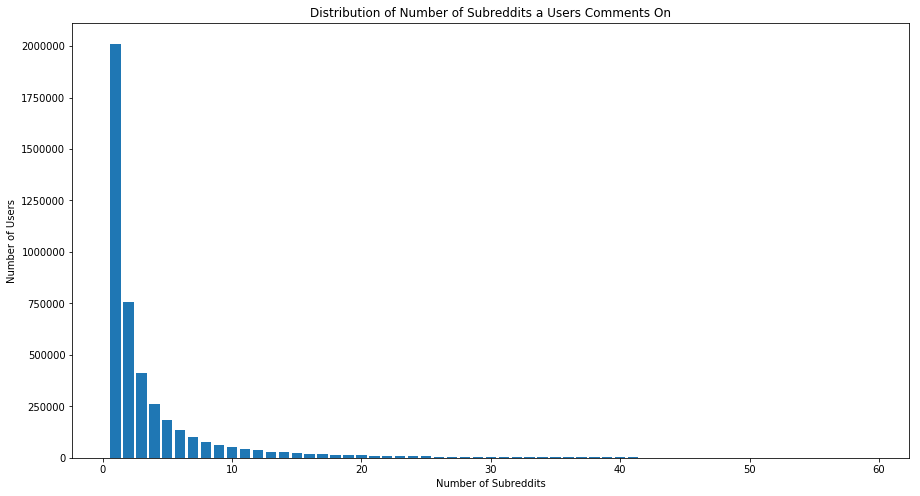

In [55]:
print "Number of average subreddits per user: ", 1.0 * len(comment_edges) /  len(users)

freq_dict = defaultdict(int)
for user, subreddits in user_subreddit_dict.iteritems():
    freq_dict[len(subreddits)] += 1

max_subreddit_count = 60
subreddit_counts = np.arange(1, max_subreddit_count)
num_users = [freq_dict[subreddit_count] for subreddit_count in subreddit_counts]
print num_users[:10]
print "Percent of users who comment on just 1 Subreddit: ", 100.0 * freq_dict[1] / len(users)
print "Percent of users who comment on just 1 or 2 Subreddits: ", 100.0 * (freq_dict[1] + freq_dict[2])/ len(users)
print "Percent of users who comment on just 1, 2, or 3 Subreddits: ", 100.0 * (freq_dict[1] + freq_dict[2] + freq_dict[3])/ len(users)

plt.title("Distribution of Number of Subreddits a Users Comments On")
plt.xlabel("Number of Subreddits")
plt.ylabel("Number of Users")
plt.bar(subreddit_counts, num_users)
plt.show()

In [12]:
##############################################
# Construct Node and Edge IDs
##############################################
def generate_node_ids(users, subreddit_ids):
    """
    Generate node ids by assigning each user a consecutive
    integer value in [0, num_users) and each subreddit
    a consecutive integer value in [num_users, num_users+num_subreddits)

    Returns dictionaries of users and subreddit_ids to their corresponding
    node ids.
    """
    num_users = len(users) # = MAX_UID
    num_subreddits = len(subreddit_ids)

    # Iterate through sorted users
    user_node_ids = {} # user -> user_node_id
    users = sorted(users)
    for user_node_id, user in enumerate(users):
        user_node_ids[user] = user_node_id

    # Iterate through sorted subreddit ids
    subreddit_node_ids = {} # subreddit_id -> subreddit_node_id
    subreddit_ids = sorted(subreddit_ids)
    for subreddit_node_id, subreddit_id in enumerate(subreddit_ids):
        subreddit_node_ids[subreddit_id] = num_users + subreddit_node_id # shifted by num_users

    return user_node_ids, subreddit_node_ids

In [13]:
user_node_ids, subreddit_node_ids = generate_node_ids(users, subreddit_ids)

## Load Bipartite User-Subreddit Graph with Snap

In [3]:
G = snap.LoadEdgeList(snap.PUNGraph, comment_graph_file, 0, 1)

## Print Basic Statistics about Graph

In [7]:
print "Number of nodes: ", G.GetNodes()
print "Number of edges: ", G.GetEdges()

# G_cluster_coeff = snap.GetClustCf(G, 1000)
# G_density = float(G.GetEdges()) / (G.GetNodes() * (G.GetNodes() - 1))

# print "Clustering Coefficient: ", G_cluster_coeff
# print "Density: ", G_density

Number of nodes:  4487984
Number of edges:  17335250


## Plot Degree Distribution Graph

In [22]:
def getFilteredDataPointsToPlot(Graph, filtered_nodes):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :filtered_nodes - list: list of Node IDs that we want to plot

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    N = len(filtered_nodes) # total number of nodes in graph

    # Get frequency counts of degree
    degreeFreq = {}
    for node_id in filtered_nodes:
        node = G.GetNI(node_id)
        degree = node.GetOutDeg()
        if degree in degreeFreq:
            degreeFreq[degree] += 1
        else:
            degreeFreq[degree] = 1

    X, Y = [], []
    for degree, count in degreeFreq.iteritems():
        count_ratio = float(count) / N
        X.append(degree)
        Y.append(count_ratio)
    return X, Y

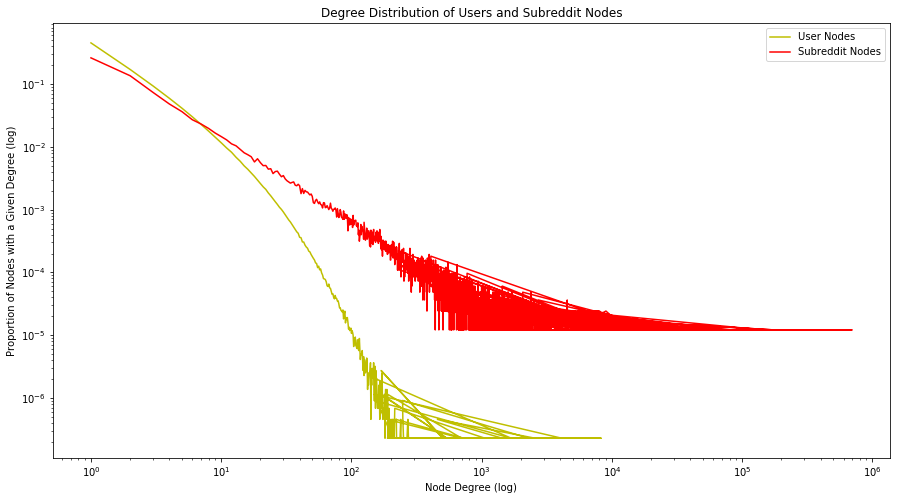

In [21]:
x_user, y_user = getFilteredDataPointsToPlot(G, filtered_nodes=user_node_ids.values())
plt.loglog(x_user, y_user, color = 'y', label = 'User Nodes')

x_subreddit, y_subreddit = getFilteredDataPointsToPlot(G, filtered_nodes=subreddit_node_ids.values())
plt.loglog(x_subreddit, y_subreddit, color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Users and Subreddit Nodes')
plt.legend()
plt.show()

## Construct User-User Graph (Shared Subreddits)

In [27]:
def construct_user_graph(G, user_node_ids, subreddit_node_ids):
    U = snap.PUNGraph.New()

    # Add user node ids
    for user, user_node_id in user_node_ids.iteritems():
        U.AddNode(user_node_id)

    # Add edges between users
    for subreddit_id, subreddit_node_id in subreddit_node_ids.iteritems():
        node = G.GetNI(subreddit_node_id)

        # Collect all subreddit neighbor nodes
        user_nodes = []
        for user_id in node.GetOutEdges():
            user_nodes.append(user_id)

        # At least two users share this subreddit
        if len(user_nodes) >= 2:
            user_pairs = list(itertools.combinations(user_nodes, 2))
            for firstNode, secondNode in user_pairs:
                U.AddEdge(firstNode, secondNode)
    
    return U

In [ ]:
U = construct_user_graph(G, user_node_ids, subreddit_node_ids)

In [ ]:
print "U: Number of nodes: ", U.GetNodes()
print "U: Number of edges: ", U.GetEdges()

U_cluster_coeff = snap.GetClustCf(U, 100)
print "U: Clustering Coefficient: ", U_cluster_coeff